# How to load and analyze data taken with the NIST Fourier Transform Spectrometer
JH 11/27/24

"fts_utils" within the quantum_sensors_tdm repo at (detechar/analysis/fts_utils.py) is the main software for analyzing data taken with the NIST FTS

In [1]:
import sys 
sys.path.append('/Users/hubmayr/nistgit/qstdm/') # change this to your directory if not already in your path

import numpy as np
import matplotlib.pyplot as plt
from detchar.analysis import fts_utils as ftsu

Below we load an "FTS Measurement Set".  I define this as a collection of "FTS measurements".  An "FTS measurement" is a set of repeated FTS scans taken consecutively.  An "FTS measurement" necessarily then contains data for a single device.  The different "FTS measurements" in the "Set" can consist of different configurations of the same detector (source temperature, FTS position, different detector bias position, etc), and also different detectors.  Th raw data for FTS sets are stored within one folder.  The folder contains the native data formats that the BlueSky FTS uses.  This python software only uses the .csv files that are created using the FTS acquisition software's "convert to ASCII" option.  This must be done on the non-networked NIST Windows XP box that controls the FTS before transfering the data to another machine (by USB!).

For this software to parse the data files properly, the file format must be of the form: "rsXX_<date>_<scan #>_ifg.csv".  Date is of the form YYMMDD, the scan number is 4 digits.  

In [2]:
fts_set = ftsu.FtsMeasurementSet('example_data/20241126/')

In [3]:
# Here you can print the meta data to tell you the main contents of the data.  This example only has 1 "measurement" 
fts_set.print_measurement_metadata()



Measurement number:  0
file_prefix :: rs29
comment :: db=5050; Tb=120mK; polarizer=0; aperture=1"
source :: 1050C
file_number_list :: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
speed :: 5.0
num_scans :: 10
num_samples :: 14543




file_prefix :: rs29
comment :: db=5050; Tb=120mK; polarizer=0; aperture=1"
source :: 1050C
file_number_list :: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
speed :: 5.0
num_scans :: 10
num_samples :: 14543


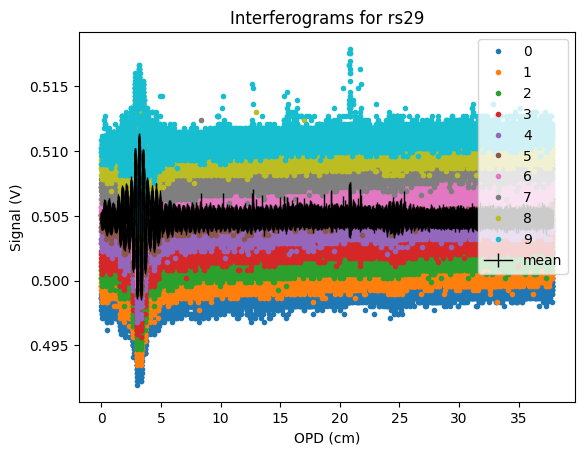

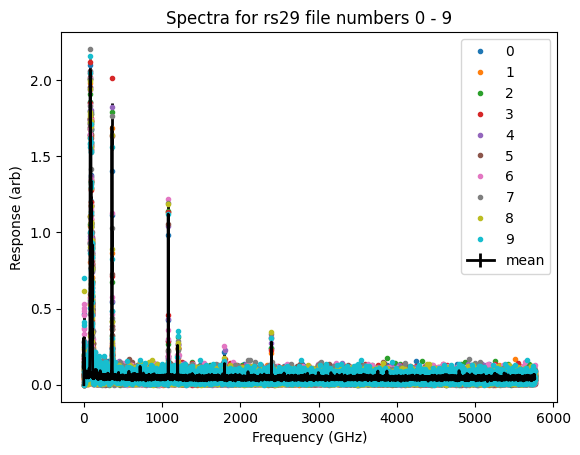

In [4]:
# plot all measurements, the individual interferograms and FFTs
fts_set.plot_all_measurements()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Phase corrected spectrum')

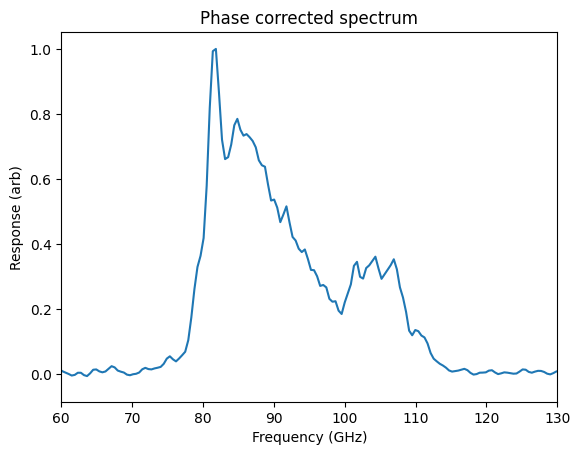

In [5]:
# plot the phase corrected averaged spectrum from the multiple scans 
fig,ax=fts_set.plot_measurements(xlim=(60,130))
ax.set_title('Phase corrected spectrum')

Text(0.5, 1.0, '(abs) FFT')

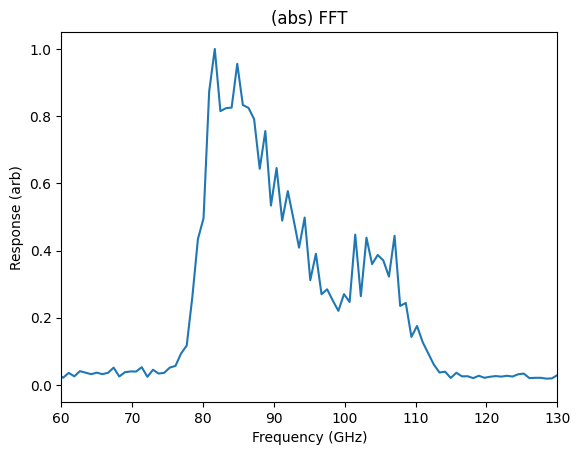

In [6]:
# plot_measurements has options for phase corrections and log versus linear.  Here is the non-phase corrected spectrum
fig,ax=fts_set.plot_measurements(phase_corrected=False,xlim=(60,130))
ax.set_title('(abs) FFT')

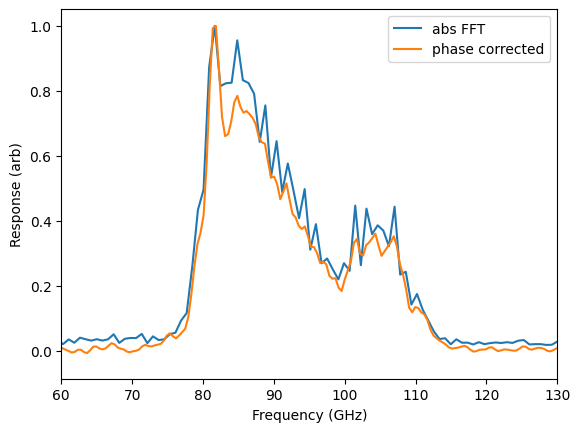

In [7]:
# you can put these on the same plot if you like
fig,ax=fts_set.plot_measurements(phase_corrected=False,xlim=(60,130))
fig,ax=fts_set.plot_measurements(phase_corrected=True,xlim=(60,130),fig=fig,ax=ax)
ax.legend(('abs FFT','phase corrected'))


The individual measurements within the set are kept within a list, which is an attribute of the FtsMeasurementSet class called "measurements."  Each element in the list is an instance of the class FtsMeasurement.  Remember that an FtsMeasurement is a set of n repeated scans.

In [8]:
type(fts_set.measurements[0])

detchar.analysis.fts_utils.FtsMeasurement

The data can be accessed by attributes of the FtsMeasurement class
"f" is the frequency vector for the non phase corrected spectra
"S" is a num_pts x num_scans array that holds the absolute value of the FFT 
"S_mean" is the mean of the n scans 
"f_phase_corr" is the phase corrected frequency vector.  It has a different length than f.
S_phase_corr is n-scan averaged the phase corrected spectrum


In [9]:
fts_set.measurements[0].S.shape

(7271, 10)

In [10]:
fts_set.measurements[0].S_phase_corr.shape

(13317,)

(60.0, 130.0)

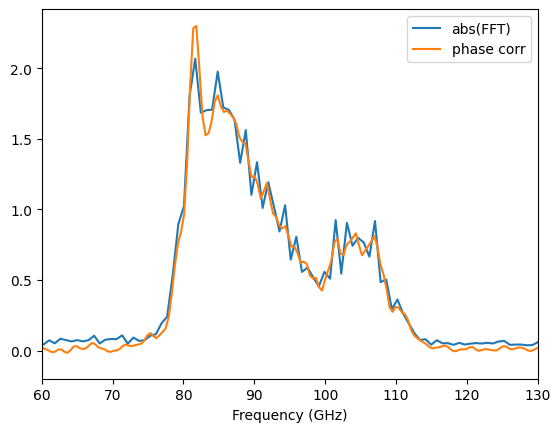

In [11]:
# to make the same plot as above (but not peak normalized), but directly accessing the data
plt.plot(fts_set.measurements[0].f, fts_set.measurements[0].S_mean)
plt.plot(fts_set.measurements[0].f_phase_corr, fts_set.measurements[0].S_phase_corr.real)
plt.legend(('abs(FFT)','phase corr'))
plt.xlabel('Frequency (GHz)')
plt.xlim(60,130)

(50.0, 250.0)

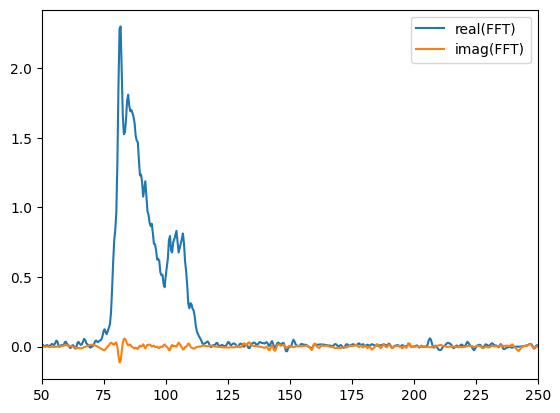

In [12]:
# or to assess how well the phase correction worked:
plt.plot(fts_set.measurements[0].f_phase_corr, fts_set.measurements[0].S_phase_corr.real)
plt.plot(fts_set.measurements[0].f_phase_corr, fts_set.measurements[0].S_phase_corr.imag)
plt.legend(('real(FFT)','imag(FFT)'))
plt.xlim(50,250)

# Use Passband class to get metrics of the passband

In [24]:
pb = ftsu.Passband(f_measure_ghz=fts_set.measurements[0].f_phase_corr,S_measure_complex=fts_set.measurements[0].S_phase_corr,f_range_ghz=[70,120])

In [25]:
pb.print_passband_metrics()

fc_measured_ghz ::  91.16257011049468  GHz
bw_measured_ghz ::  27.988779578221365  GHz
fc_model_ghz ::  None  GHz
bw_model_ghz ::  None  GHz


(60.0, 130.0)

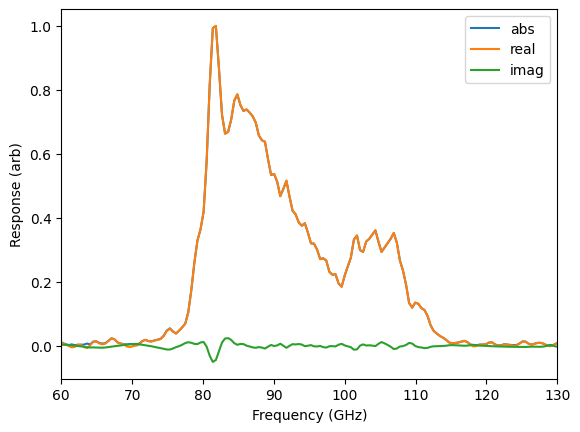

In [19]:
fig,ax=pb.plot()
ax.set_xlim((60,130))

If you have a passband model, you can add this to the class to compare

In [28]:
dd = np.loadtxt('example_data/class_passband_model.csv',delimiter=',',skiprows=1)

In [29]:
pb = ftsu.Passband(f_measure_ghz=fts_set.measurements[0].f_phase_corr,S_measure_complex=fts_set.measurements[0].S_phase_corr,
                   f_model_ghz=dd[:,0], S_model=dd[:,1],f_range_ghz=[70,120])

In [30]:
pb.print_passband_metrics()

fc_measured_ghz ::  91.16257011049468  GHz
bw_measured_ghz ::  27.988779578221365  GHz
fc_model_ghz ::  92.61403965482462  GHz
bw_model_ghz ::  33.64295695823455  GHz


(50.0, 150.0)

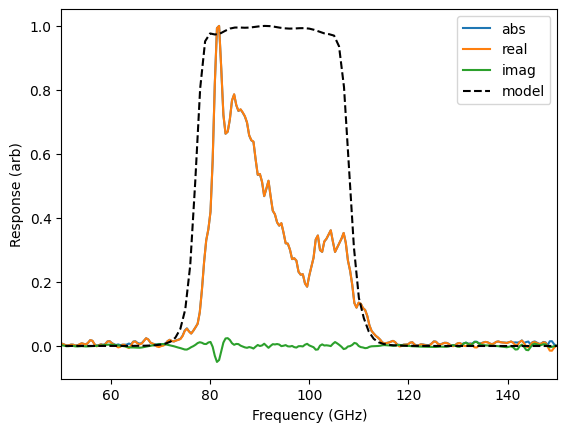

In [34]:
fig,ax=pb.plot()
ax.set_xlim((50,150))

Is the calculation of effective bandwidth correct (bw_measured_ghz)?  How could it be that the measured bandwidth is only 5.6 GHz less than the modeled/designed?  The area under the curve looks a factor of 2 different.   